In [47]:
import numpy as np
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [48]:
# opening the file in read mode 
my_file = open("../data/names.txt", "r") 
# reading the file 
data = my_file.read()
# split the names into a list
name_list = data.split('\n')
name_list = ["."+x for x in name_list]

chartoix = {char: ix for ix, char in enumerate(sorted(set("".join(name_list))))}
ixtochar = {ix: char for ix, char in enumerate(sorted(set("".join(name_list))))}

block_size = 3
def build_x_y(name_list, block_size):
    # Create a dataset with, for each example, all possible X and Y combinations we can extract from it
    y_list = []
    x_list = []
    for name in name_list:
        for target_ix, target_letter in enumerate(name):
            previous_letters = name[max(-(block_size)+target_ix,0):target_ix] # This will extract the previous 3 letters
            num_pads = block_size - len(previous_letters)
            previous_letters = "."*num_pads + previous_letters
            #print(previous_letters + "-->" + target_letter)
            y_list.append(chartoix[target_letter])
            x_list.append([chartoix[input_letter] for input_letter in previous_letters])
            
    X = torch.tensor(x_list) # Tensor with 3 dimensional list, input letter index
    Y = torch.tensor(y_list) # Tensor with 1 dimensional output
    return X,Y

ix_80_pct = int(0.8*len(name_list))
ix_90_pct = int(0.9*len(name_list))

X_train, Y_train = build_x_y(name_list[:ix_80_pct],block_size=block_size)
X_val, Y_val= build_x_y(name_list[ix_80_pct:ix_90_pct],block_size=block_size)
X_test, Y_test = build_x_y(name_list[ix_90_pct:],block_size=block_size)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182778, 3]),
 torch.Size([182778]),
 torch.Size([22633, 3]),
 torch.Size([22633]),
 torch.Size([22735, 3]),
 torch.Size([22735]))

In [49]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5 #Kaimin initialisation
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x): #Forward pass
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        #parameters for scaling the batchnorm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #running mean and std
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x): #Forward pass can be during training or inference depending on self.training
           
        if self.training:
            batch_mean_i = x.mean(0,keepdims=True) 
            batch_var_i = x.var(0,keepdims=True)

            with torch.no_grad():
                self.running_mean = (1-momentum)*self.running_mean + momentum*batch_mean_i
                self.running_var = (1-momentum)*self.running_var + momentum*batch_var_i

        else:
            
            batch_mean_i = self.running_mean
            batch_var_i = self.running_var

        x_hat = x - batch_mean_i / torch.sqrt(batch_var_i + self.eps)
        self.out = self.gamma * x_hat + self.beta

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [50]:
n_embd = 10
n_hidden = 100
vocab_size = len(chartoix)
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(block_size*n_embd, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# We scale down the last layer's weights before giving the final output
with torch.no_grad():
    layers[-1].weight *= 0.1 #for the last layer only
    for layer in layers[:-1]: 
        if isinstance(layer,Linear): #for all other layers
            layer.weight *= 5/3 # This is the gain of the Kaiming init for tanh. The / sqrt(n) is already part of the class

parameters = [[C]] + [layer.parameters() for layer in layers]
flattened_params = [item for sublist in parameters for item in sublist]

In [51]:
print(f"Total number of params: {sum([params.nelement() for params in flattened_params])}")

Total number of params: 46497


In [52]:
for p in flattened_params:
    p.requires_grad = True

In [53]:
steps = 100000
batch_size = 32
lossi = []
for i in range(steps):
    ###### Minibatch #######
    minibatch_ix = torch.randint(0,len(X_train),(batch_size,), generator = g)
    Xb, Yb = X_train[minibatch_ix], Y_train[minibatch_ix]
    
    ###### Forward pass ########
    embs = C[Xb]
    x = embs.view(embs.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    ###### Backward pass ########
    for layer in layers:
        layer.out.retain_grad()
    for p in flattened_params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01
    for p in flattened_params:
        p.data += -lr*p.grad

    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
    lossi.append(loss.item())

Iteration 0, Loss: 3.835615396499634
Iteration 1000, Loss: 2.3101096153259277
Iteration 2000, Loss: 2.1977717876434326
Iteration 3000, Loss: 1.7147551774978638
Iteration 4000, Loss: 2.068455696105957
Iteration 5000, Loss: 2.1486518383026123
Iteration 6000, Loss: 1.9925795793533325
Iteration 7000, Loss: 2.31303071975708
Iteration 8000, Loss: 2.536254405975342
Iteration 9000, Loss: 2.141249895095825
Iteration 10000, Loss: 1.8326630592346191
Iteration 11000, Loss: 2.137824058532715
Iteration 12000, Loss: 1.965027093887329
Iteration 13000, Loss: 1.8927412033081055
Iteration 14000, Loss: 1.7326115369796753
Iteration 15000, Loss: 2.3985354900360107
Iteration 16000, Loss: 1.916867971420288
Iteration 17000, Loss: 2.4486608505249023
Iteration 18000, Loss: 2.310098171234131
Iteration 19000, Loss: 1.9837645292282104
Iteration 20000, Loss: 1.9946435689926147
Iteration 21000, Loss: 1.7928227186203003
Iteration 22000, Loss: 2.0167088508605957
Iteration 23000, Loss: 1.9258376359939575
Iteration 24000

Saturation layer 1: 32.78%
Saturation layer 3: 32.00%
Saturation layer 5: 36.31%
Saturation layer 7: 32.38%
Saturation layer 9: 17.19%


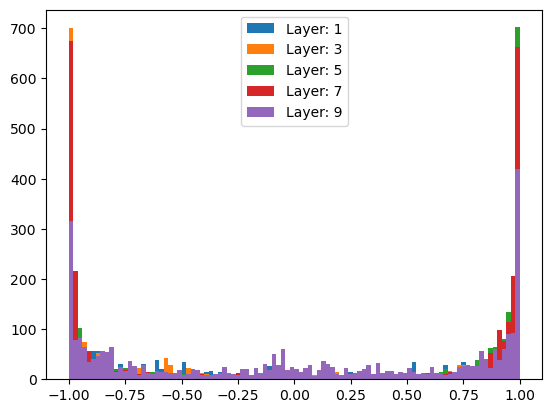

In [54]:
# Let's investigate whats happening to the activations in each layer (after Tanh)
plt.figure()
with torch.no_grad():
    for layer_ix, layer in enumerate(layers[:-1]): 
        if isinstance(layer,Tanh): #for all other layers
            output = layer.out
            output_vals = layer.out.view(-1).tolist()
            print(f"Saturation layer {layer_ix}: {100*(np.abs(output_vals) > 0.99).sum() / len(output_vals):.2f}%")
            plt.hist(output_vals,bins=100,label=f"Layer: {layer_ix}")
plt.legend()            
plt.show()

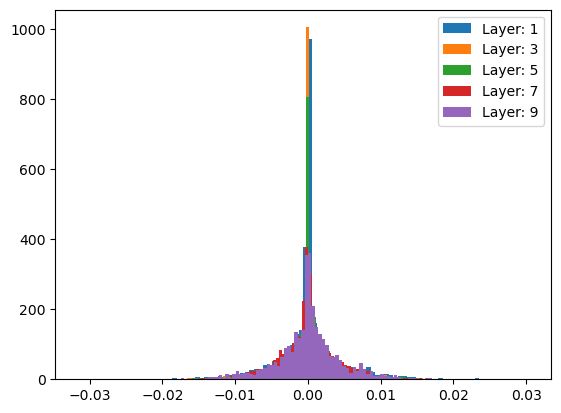

In [57]:
# Let's investigate whats happening to the gradients in each layer (after Tanh)
plt.figure()
with torch.no_grad():
    for layer_ix, layer in enumerate(layers[:-1]): 
        if isinstance(layer,Tanh): #for all other layers
            output = layer.out.grad
            output_vals = output.view(-1).tolist()
            plt.hist(output_vals,bins=100,label=f"Layer: {layer_ix}")
plt.legend()            
plt.show()

In [58]:
# Let's investigate the gradient updates to the weights specifically
with torch.no_grad():
    for params in flattened_params:
        if params.ndim == 2: #We dont care about biases, or batchnorm parameters
            vals = params.view(-1).tolist()
            grads = params.grad.view(-1).tolist()
            grad_data_ratio = (params.grad/params).view(-1).tolist()
            print(f"{params.shape}   |  Mean: {np.mean(vals):.3f}      | Std: {np.std(vals):.3f}  |  G/D ratio: {np.mean(grad_data_ratio):.3f}")

torch.Size([27, 10])   |  Mean: -0.004      | Std: 1.141  |  G/D ratio: 0.013
torch.Size([30, 100])   |  Mean: 0.008      | Std: 0.396  |  G/D ratio: 0.092
torch.Size([100, 100])   |  Mean: -0.003      | Std: 0.234  |  G/D ratio: -0.040
torch.Size([100, 100])   |  Mean: -0.000      | Std: 0.229  |  G/D ratio: -0.037
torch.Size([100, 100])   |  Mean: 0.003      | Std: 0.224  |  G/D ratio: -0.596
torch.Size([100, 100])   |  Mean: -0.003      | Std: 0.203  |  G/D ratio: -0.066
torch.Size([100, 27])   |  Mean: -0.000      | Std: 0.174  |  G/D ratio: -1.796
